**Flow:**



*   Download dataset from G-Drive
*   Pre-processing: duplicate and null check
*   EDA:
> understand relation - univariate, bivariate, correlation -- charts

*   Model Building / Predictive Analysis:

> Data transform: delete columns like ID, batch etc after EDA

> SPSS: analysis for PCA, which columns can be removed

> Model Iter - 1: Test few models with all columns:
different set of columns and compare with all columns; which gives better results

> Model Iter - 2: Test again after removing some columns with less Eigen values suggested by SPSS

> Model Iter - 3: Test again after removing few more columns

> Compare Iter 1, 2 & 3:
as no model is giving some significant results, use resampling and try again

> Model Training with Resampling

**Submission - 2**

> Try out 2 more models:
* Logistic Regression - compare: basic model, with L1 and L2 penalty, and tuning
* SVM - compare basic model and tuning

> Hyperparameter tuning for the best model from resampling (XGBoost):
Model which are giving better results with resampling, try to tune hyperparameters for optimum performance

> Try scaling on best model with resampling and tuned hyperparameter
try scaling for columns with large variance and conclude whether scaling is useful or not


##Download Dataset

In [1]:
#download dataset
!gdown '1SCWj_Nqql59TOgSZKoSkS9Y5jLJZOSk2'

Downloading...
From: https://drive.google.com/uc?id=1SCWj_Nqql59TOgSZKoSkS9Y5jLJZOSk2
To: /content/loan default prediction_train.csv
100% 17.3M/17.3M [00:00<00:00, 73.0MB/s]


##Libraries

In [68]:
#library functions to be used
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model  import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.metrics import log_loss, f1_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

##Preprocessing

In [3]:
#loading dataset to dataframe
train_df = pd.read_csv('loan default prediction_train.csv')
train_df.head(2)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0


In [4]:
#checking distinct classes with count
train_df['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

In [5]:
#checking duplicates
train_df.duplicated().sum()

0

In [6]:
#checking null
train_df.isna().sum()

ID                              0
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Employment Duration             0
Home Ownership                  0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay 

##EDA

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [8]:
train_df.describe()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,6.746300e+04,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,...,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.0,67463.000000,6.746300e+04,67463.000000,67463.000000
mean,2.562761e+07,16848.902776,15770.599114,14621.799323,58.173814,11.846258,80541.502522,23.299241,0.327127,0.145754,...,1.143969,59.691578,1.125141,0.021301,71.163260,0.0,146.467990,1.595739e+05,23123.005544,0.092510
std,2.109155e+07,8367.865726,8150.992662,6785.345170,3.327441,3.718629,45029.120366,8.451824,0.800888,0.473291,...,5.244365,357.026346,3.489885,0.144385,43.315845,0.0,744.382233,1.390332e+05,20916.699999,0.289747
min,1.297933e+06,1014.000000,1014.000000,1114.590204,36.000000,5.320006,14573.537170,0.675299,0.000000,0.000000,...,0.000003,0.000036,0.000036,0.000000,0.000000,0.0,1.000000,6.170000e+02,1000.000000,0.000000
25%,6.570288e+06,10012.000000,9266.500000,9831.684984,58.000000,9.297147,51689.843335,16.756416,0.000000,0.000000,...,0.021114,1.629818,0.476259,0.000000,35.000000,0.0,24.000000,5.037900e+04,8155.500000,0.000000
50%,1.791565e+07,16073.000000,13042.000000,12793.682170,59.000000,11.377696,69335.832680,22.656658,0.000000,0.000000,...,0.043398,3.344524,0.780141,0.000000,68.000000,0.0,36.000000,1.183690e+05,16733.000000,0.000000
75%,4.271521e+07,22106.000000,21793.000000,17807.594120,59.000000,14.193533,94623.322785,30.048400,0.000000,0.000000,...,0.071884,5.453727,1.070566,0.000000,105.000000,0.0,46.000000,2.283750e+05,32146.500000,0.000000
max,7.224578e+07,35000.000000,34999.000000,34999.746430,59.000000,27.182348,406561.536400,39.629862,8.000000,5.000000,...,42.618882,4354.467419,166.833000,1.000000,161.000000,0.0,16421.000000,1.177412e+06,201169.000000,1.000000


###Dividing into Categorical and Numerical columns

In [9]:
#categorical column names and count
categorical_columns = [i for i in train_df.select_dtypes(include='object').columns]
print(f'Categorical Column Names: {categorical_columns}')
print(f'#Categorical Columns: {len(categorical_columns)}')

Categorical Column Names: ['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Loan Title', 'Initial List Status', 'Application Type']
#Categorical Columns: 9


In [10]:
#unique values in categorical columns
for i in categorical_columns:
    print("The no.of unique values in",i,"are: ",train_df.loc[:,i].nunique())

The no.of unique values in Batch Enrolled are:  41
The no.of unique values in Grade are:  7
The no.of unique values in Sub Grade are:  35
The no.of unique values in Employment Duration are:  3
The no.of unique values in Verification Status are:  3
The no.of unique values in Payment Plan are:  1
The no.of unique values in Loan Title are:  109
The no.of unique values in Initial List Status are:  2
The no.of unique values in Application Type are:  2


'Grade', 'Employment Duration', 'Verification Status', 'Initial List Status' and 'Application Type' have less distinct values and one hot encoding can be used for these columns.


'Batch Enrolled', 'Sub Grade', 'Loan Title' have high distinct values as  41, 35 and 109. One hot encoding will increase #columns drastically for these features. Must find a way to handle these values.

'Payment Plan' just has 1 value hence can be dropped as a feature for model training.

Batch Enrolled: BAT3873588    3626
BAT1586599    3142
BAT1104812    2996
BAT2252229    2557
BAT2803411    2425
BAT1780517    2403
BAT1184694    2298
BAT2078974    2290
BAT2575549    2257
BAT4694572    2248
BAT4271519    2054
BAT2558388    1963
BAT3193689    1864
BAT1930365    1844
BAT2136391    1790
BAT2333412    1775
BAT3726927    1774
BAT4136152    1766
BAT5341619    1717
BAT5525466    1709
BAT5489674    1677
BAT5629144    1639
BAT1766061    1461
BAT2833642    1421
BAT5924421    1404
BAT2522922    1399
BAT2428731    1398
BAT4808022    1303
BAT4351734    1140
BAT5547201    1127
BAT5714674    1105
BAT3461431    1068
BAT224923      895
BAT1761981     894
BAT4722912     887
BAT2003848     842
BAT1467036     802
BAT5849876     768
BAT3865626     728
BAT5811547     711
BAT1135695     296
Name: Batch Enrolled, dtype: int64


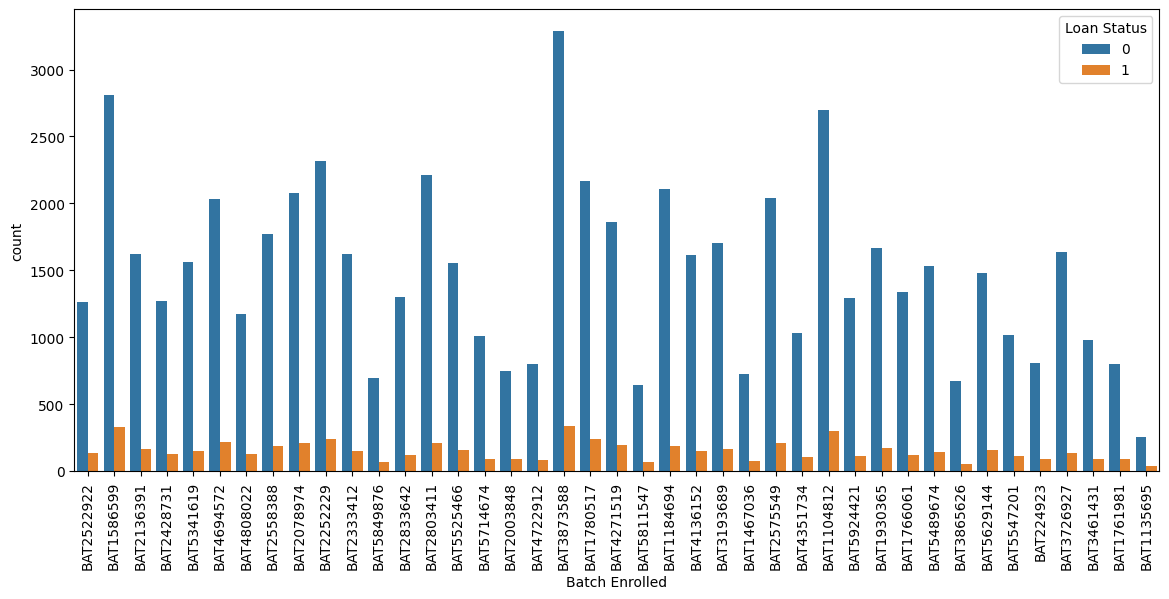




Grade: C    19085
B    18742
A    12055
D     8259
E     6446
F     2246
G      630
Name: Grade, dtype: int64


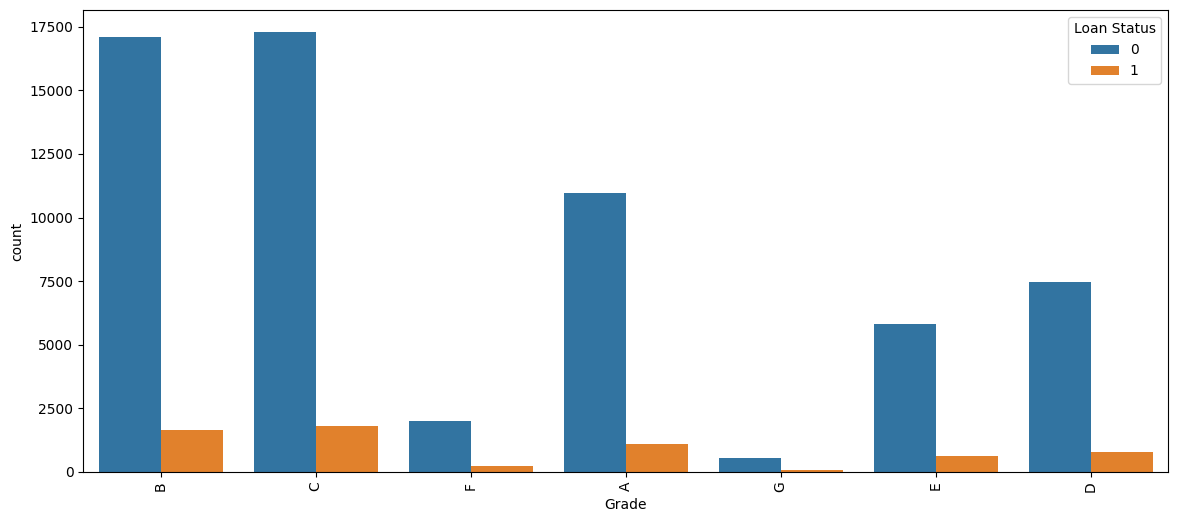




Sub Grade: B4    4462
C1    4188
B3    3999
A5    3540
B2    3520
B5    3408
D1    3304
C4    3250
C2    3219
C3    3121
B1    2924
C5    2472
A4    2264
D4    2050
D2    1963
D5    1952
A2    1837
D3    1824
E2    1746
A3    1685
A1    1364
E3    1321
E1    1298
E4    1117
F2     947
F1     824
E5     769
F5     582
F3     578
G2     447
F4     441
G1     366
G5     284
G3     246
G4     151
Name: Sub Grade, dtype: int64


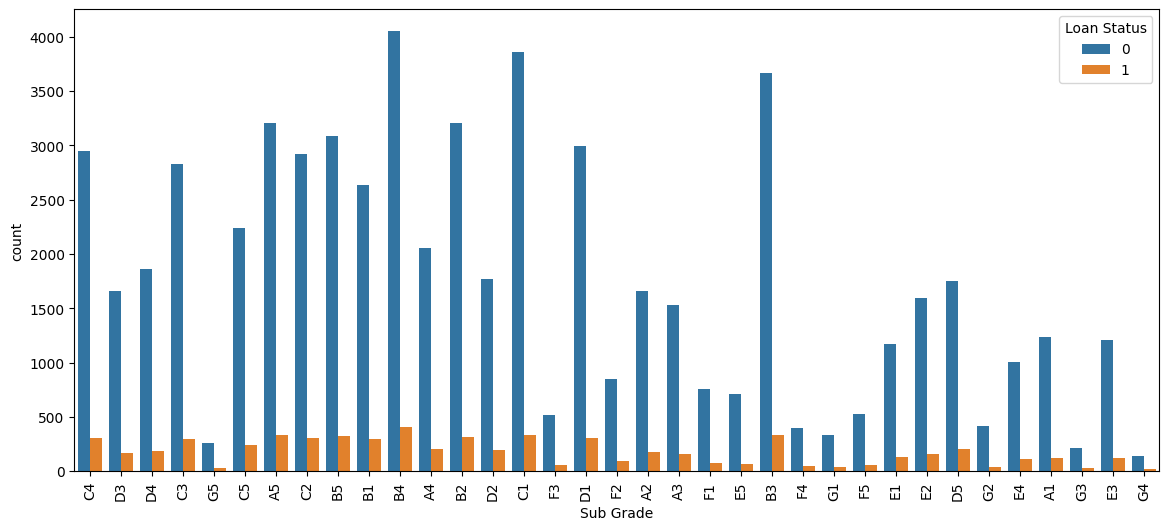




Employment Duration: MORTGAGE    36351
RENT        24150
OWN          6962
Name: Employment Duration, dtype: int64


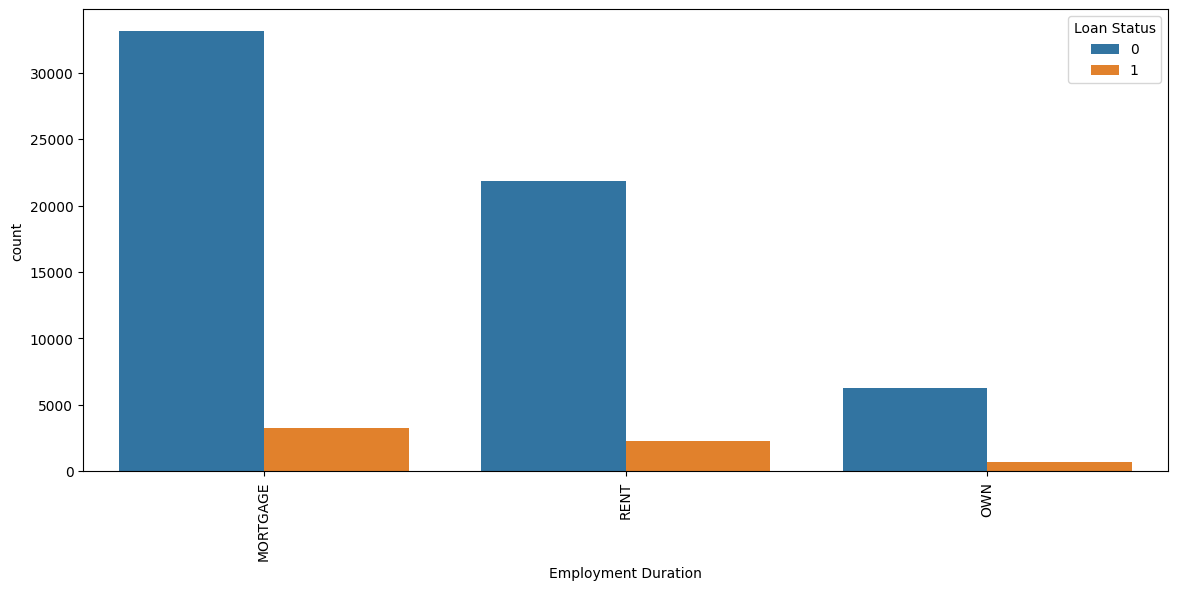




Verification Status: Source Verified    33036
Verified           18078
Not Verified       16349
Name: Verification Status, dtype: int64


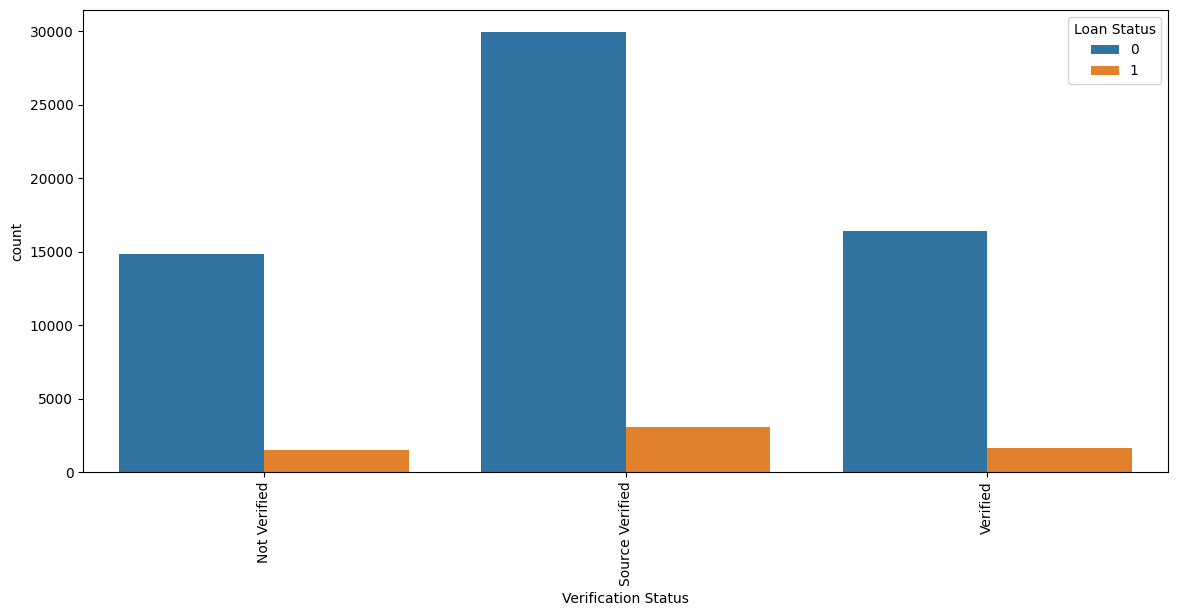




Payment Plan: n    67463
Name: Payment Plan, dtype: int64


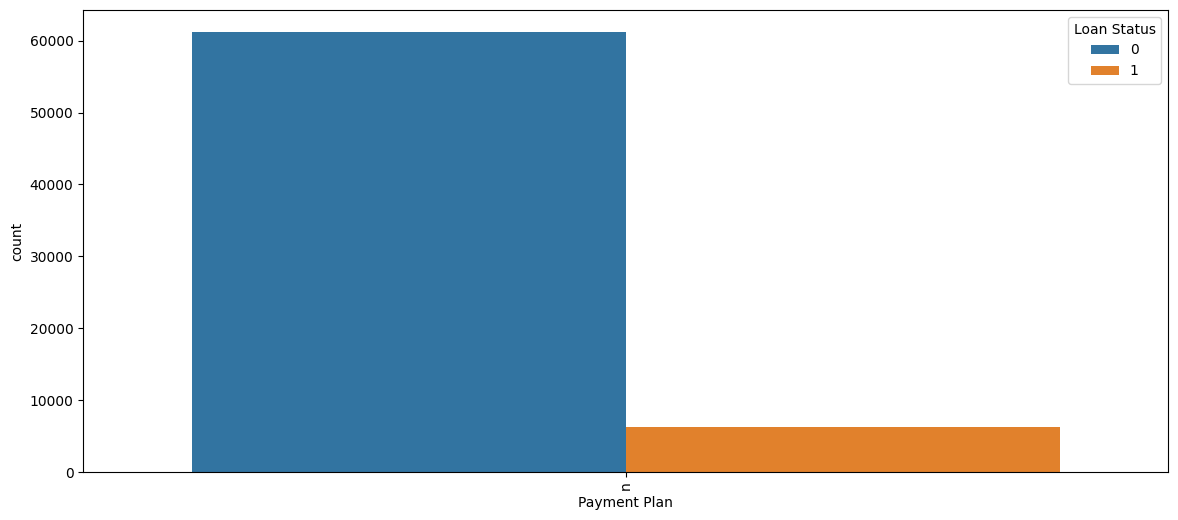




Loan Title: Credit card refinancing    30728
Debt consolidation         24841
Debt Consolidation          3544
Other                       2455
Home improvement            2211
                           ...  
Home loan                      6
Personal loan                  5
Getting Ahead                  5
Credit                         4
bills                          4
Name: Loan Title, Length: 109, dtype: int64


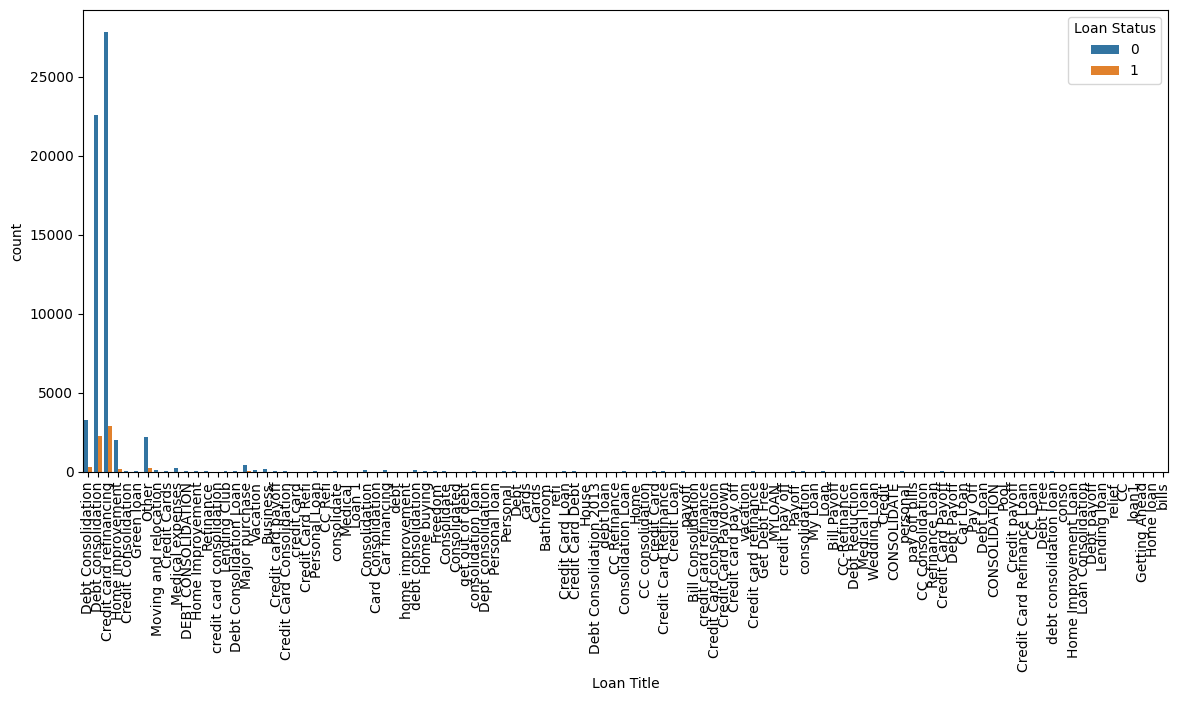




Initial List Status: w    36299
f    31164
Name: Initial List Status, dtype: int64


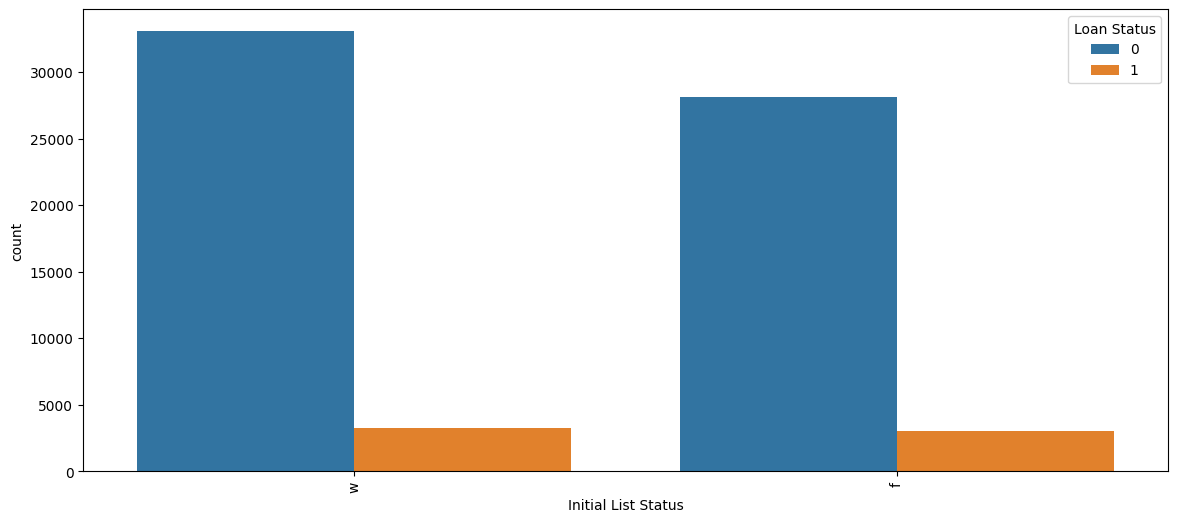




Application Type: INDIVIDUAL    67340
JOINT           123
Name: Application Type, dtype: int64


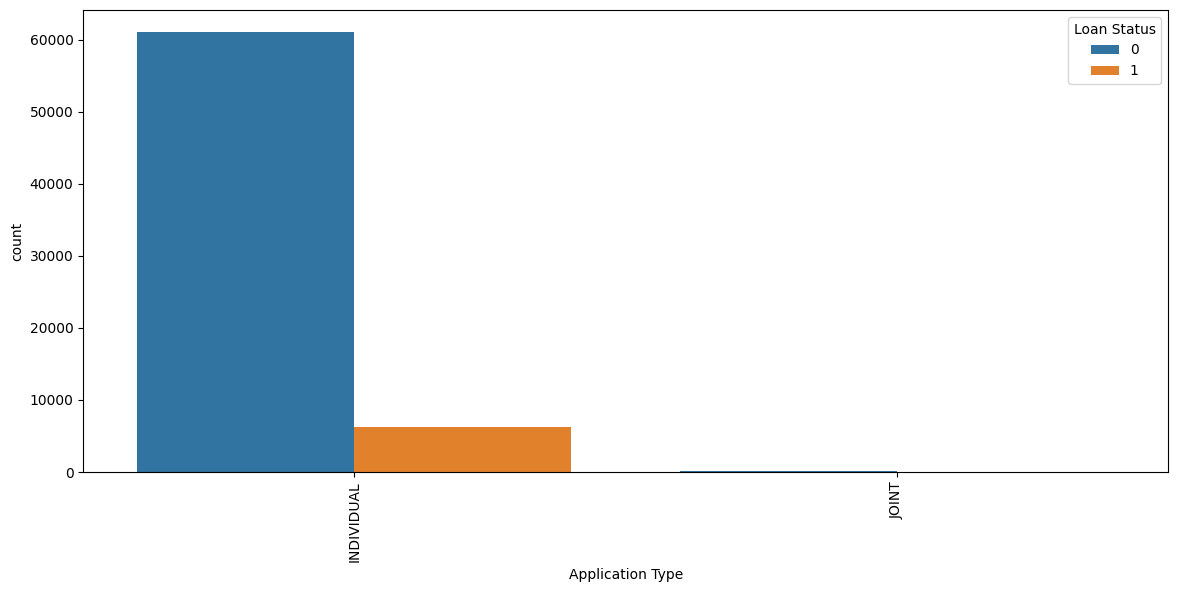

In [11]:
#visual analysis on categorical columns
for col_name in categorical_columns:
  print(f'{col_name}: {train_df[col_name].value_counts()}')
  plt.figure(figsize=(14,6))
  plt.xticks(rotation=90)
  sns.countplot(data=train_df,x=col_name,hue='Loan Status')
  plt.show()
  print('\n\n')

In [12]:
#numerical columns and their counts
numeric_columns = [i for i in train_df.select_dtypes(exclude='object').columns]

print(f'Numerical Column Names: {numeric_columns}')
print(f'#Numerical Columns: {len(numeric_columns)}')

Numerical Column Names: ['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']
#Numerical Columns: 26


In [13]:
#unique values in numerical columns
for i in numeric_columns:
    print("The no.of unique values in",i,"are: ",train_df.loc[:,i].nunique())

The no.of unique values in ID are:  67463
The no.of unique values in Loan Amount are:  27525
The no.of unique values in Funded Amount are:  24548
The no.of unique values in Funded Amount Investor are:  67441
The no.of unique values in Term are:  3
The no.of unique values in Interest Rate are:  67448
The no.of unique values in Home Ownership are:  67454
The no.of unique values in Debit to Income are:  67454
The no.of unique values in Delinquency - two years are:  9
The no.of unique values in Inquires - six months are:  6
The no.of unique values in Open Account are:  36
The no.of unique values in Public Record are:  5
The no.of unique values in Revolving Balance are:  20582
The no.of unique values in Revolving Utilities are:  67458
The no.of unique values in Total Accounts are:  69
The no.of unique values in Total Received Interest are:  67451
The no.of unique values in Total Received Late Fee are:  67380
The no.of unique values in Recoveries are:  67387
The no.of unique values in Collec

'ID' feature has all unique values, either we can convert this to index or can drop this feature.

'Accounts Delinquent' just have one value, hence, can be dropped.

Rest columns which have large numerical values like loan amount can be scaled.

###Univariate Analysis

Term: 59    43780
58    22226
36     1457
Name: Term, dtype: int64


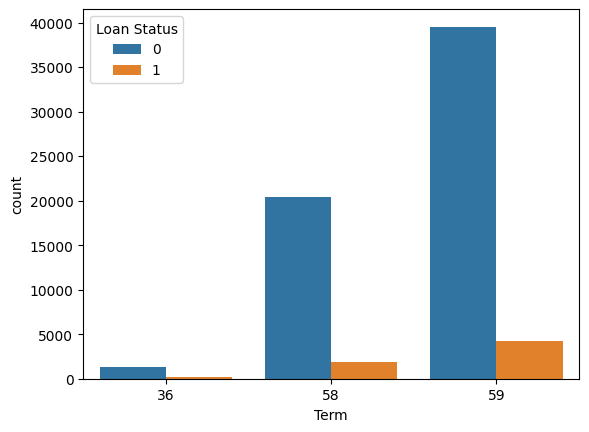



Delinquency - two years: 0    52054
1    11736
2     2651
3      445
7      252
6      191
5       74
8       44
4       16
Name: Delinquency - two years, dtype: int64


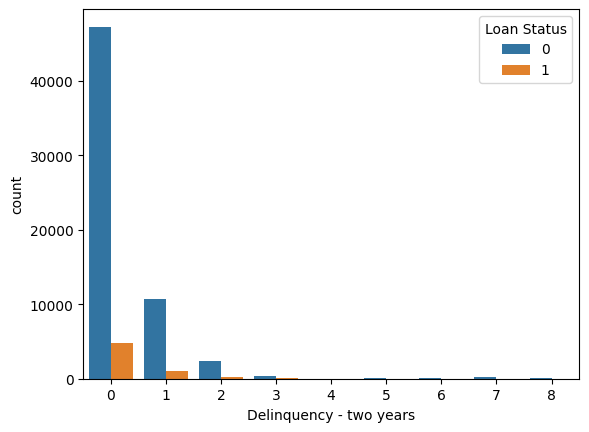



Inquires - six months: 0    60486
1     4558
2     2042
3      320
4       54
5        3
Name: Inquires - six months, dtype: int64


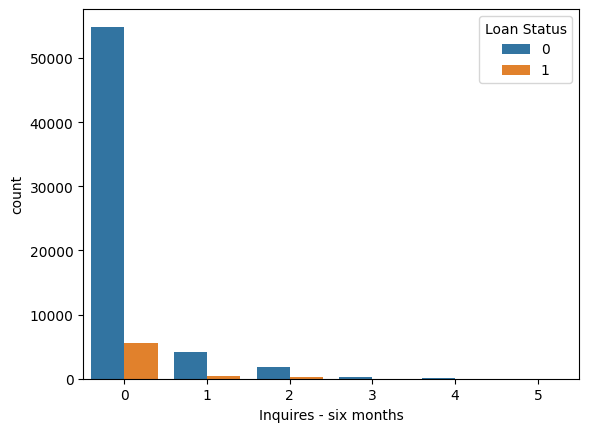



Public Record: 0    62871
1     4133
2      200
4      184
3       75
Name: Public Record, dtype: int64


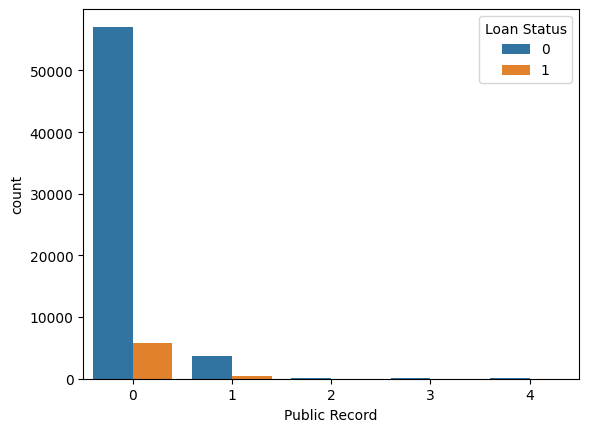



Collection 12 months Medical: 0    66026
1     1437
Name: Collection 12 months Medical, dtype: int64


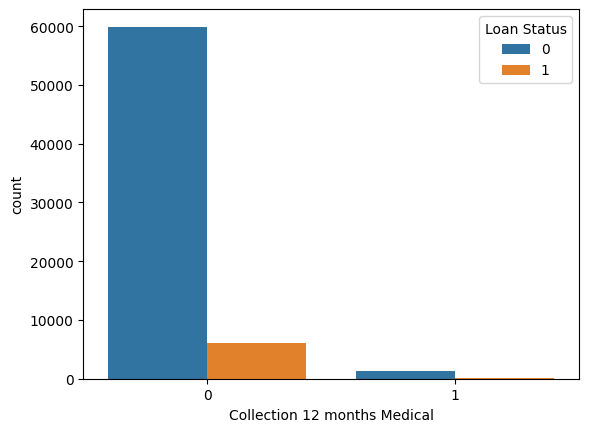

In [14]:
#checking numeric values with less cardinality: 'Term', 'Delinquency - two years', 'Inquires - six months', 'Public Record', 'Collection 12 months Medical'

print(f'Term: {train_df["Term"].value_counts()}')
sns.countplot(data=train_df,x='Term',hue='Loan Status')
plt.show()

print(f'\n\nDelinquency - two years: {train_df["Delinquency - two years"].value_counts()}')
sns.countplot(data=train_df,x='Delinquency - two years',hue='Loan Status')
plt.show()

print(f'\n\nInquires - six months: {train_df["Inquires - six months"].value_counts()}')
sns.countplot(data=train_df,x='Inquires - six months',hue='Loan Status')
plt.show()

print(f'\n\nPublic Record: {train_df["Public Record"].value_counts()}')
sns.countplot(data=train_df,x='Public Record',hue='Loan Status')
plt.show()

print(f'\n\nCollection 12 months Medical: {train_df["Collection 12 months Medical"].value_counts()}')
sns.countplot(data=train_df,x='Collection 12 months Medical',hue='Loan Status')
plt.show()

In [15]:
#column has only one value
train_df['Accounts Delinquent'].value_counts()

0    67463
Name: Accounts Delinquent, dtype: int64

In [16]:
#removing 'Term', 'Delinquency - two years', 'Inquires - six months', 'Public Record', 'Collection 12 months Medical' from numerical cols
#also removing 'Accounts Delinquent' as it just has 1 value; Dependent variable: 'Loan Status'
##num_cols = ['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Total Accounts']

#finalizing numeric columns (18)
num_cols = ['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Open Account', 'Revolving Balance', 'Revolving Utilities', 'Total Accounts', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee', 'Last week Pay', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit']

len(num_cols)

18

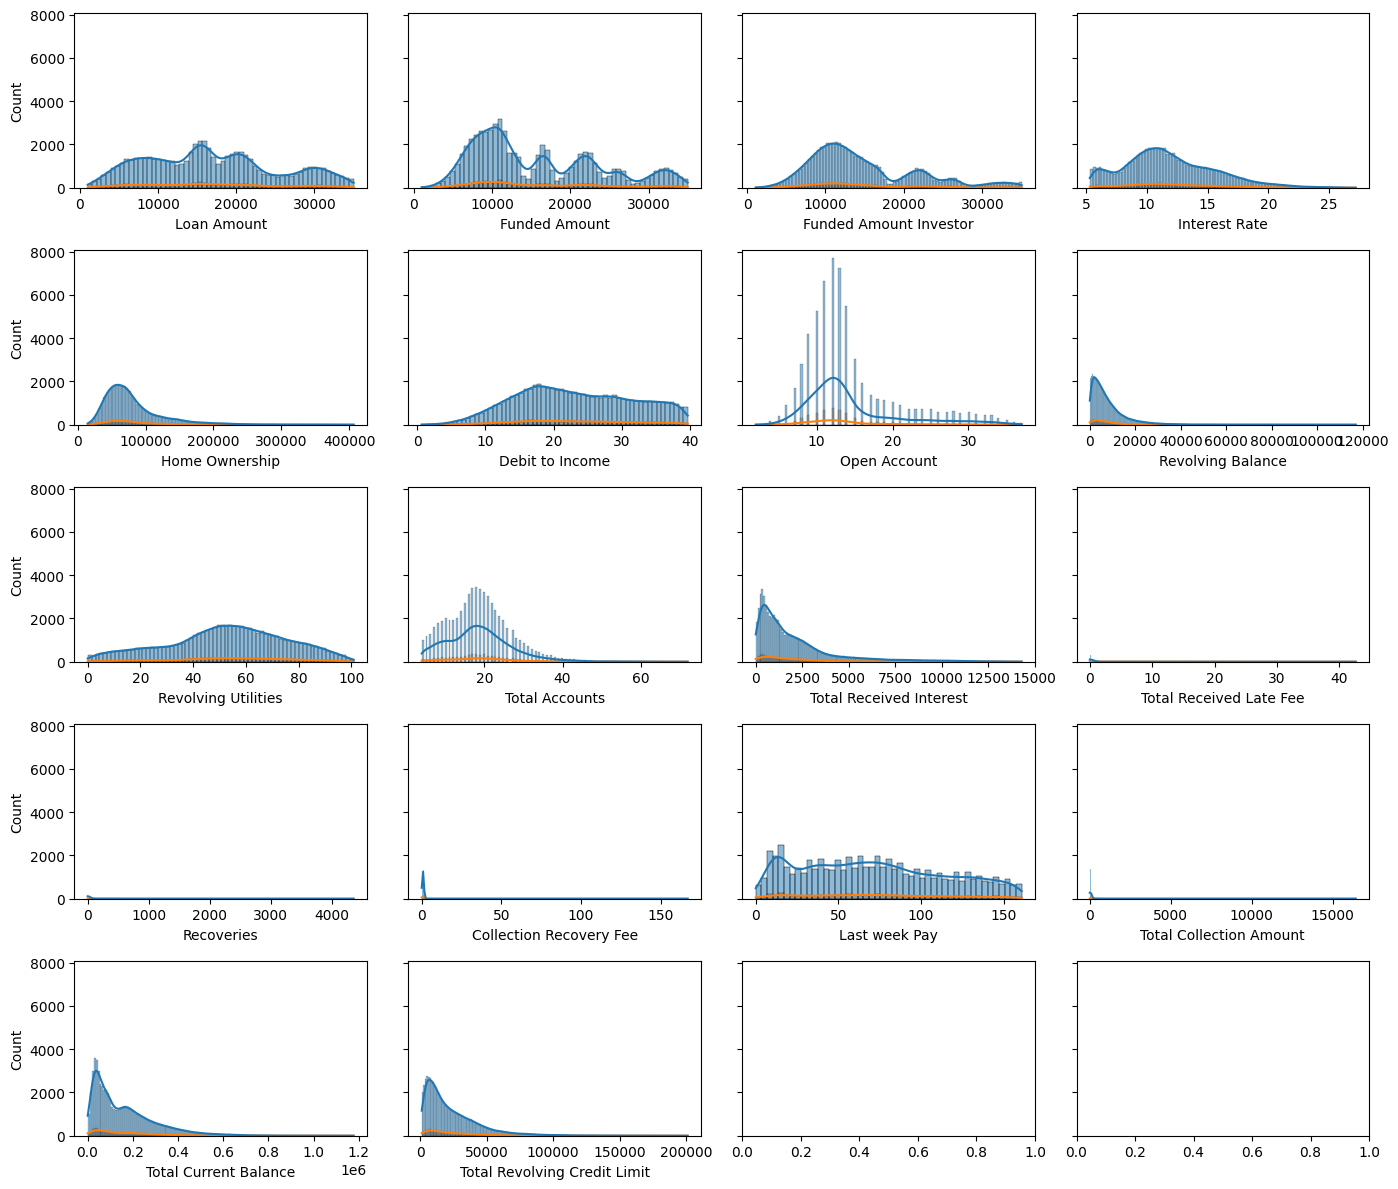

In [17]:
#plotting in sub-plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 12), sharex=False, sharey=True)
axes = axes.ravel()
i = 0

for col_name in num_cols:
  sns.histplot(data=train_df, x=col_name, kde=True, hue='Loan Status', ax=axes[i], legend=False)
  i+=1

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loan Amount vs Interest Rate by Loan Status')

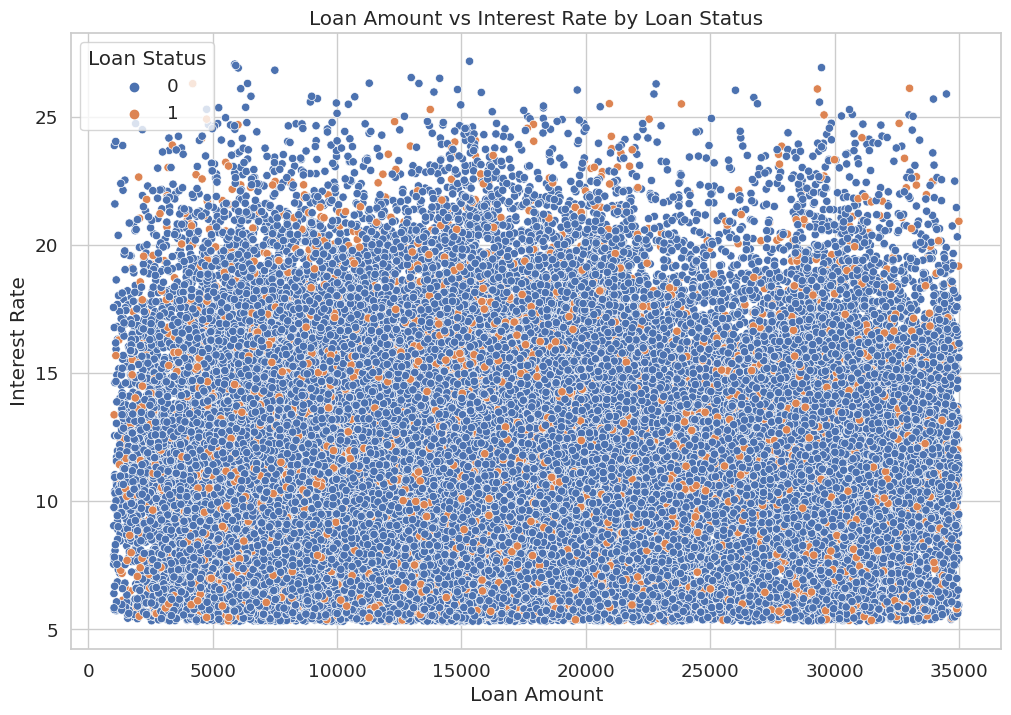

In [18]:
#scatter plot for bivariate analysis
#set up the figure
sns.set(style="whitegrid", font_scale=1.2)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

#create the visualization
sns.scatterplot(x="Loan Amount", y="Interest Rate", hue="Loan Status", data=train_df, ax=ax)

#set the labels and title
ax.set_xlabel("Loan Amount")
ax.set_ylabel("Interest Rate")
ax.set_title("Loan Amount vs Interest Rate by Loan Status")

###Multivariate Analysis

In [19]:
train_df.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

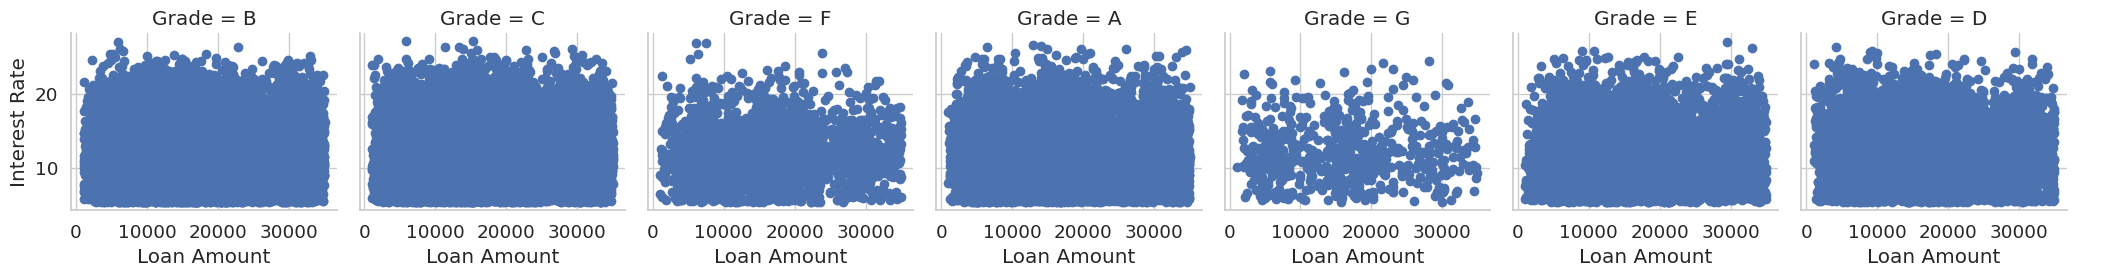

In [20]:
#multivariate analysis between different columns
sns.FacetGrid(data = train_df, col = 'Grade').map(plt.scatter, 'Loan Amount', 'Interest Rate').add_legend()
plt.show()

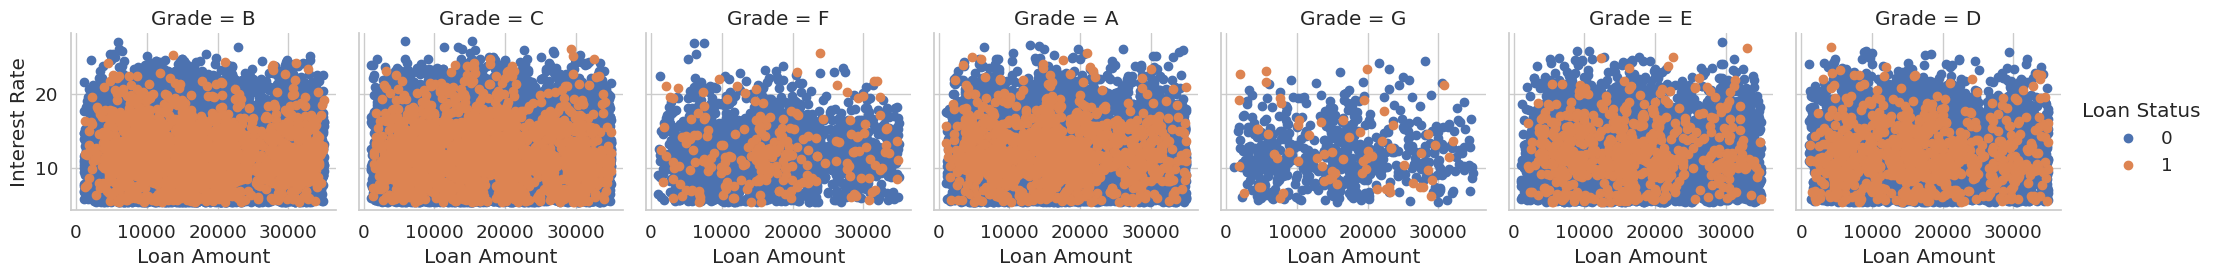

In [21]:
sns.FacetGrid(data = train_df, col = 'Grade', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Interest Rate').add_legend()
plt.show()

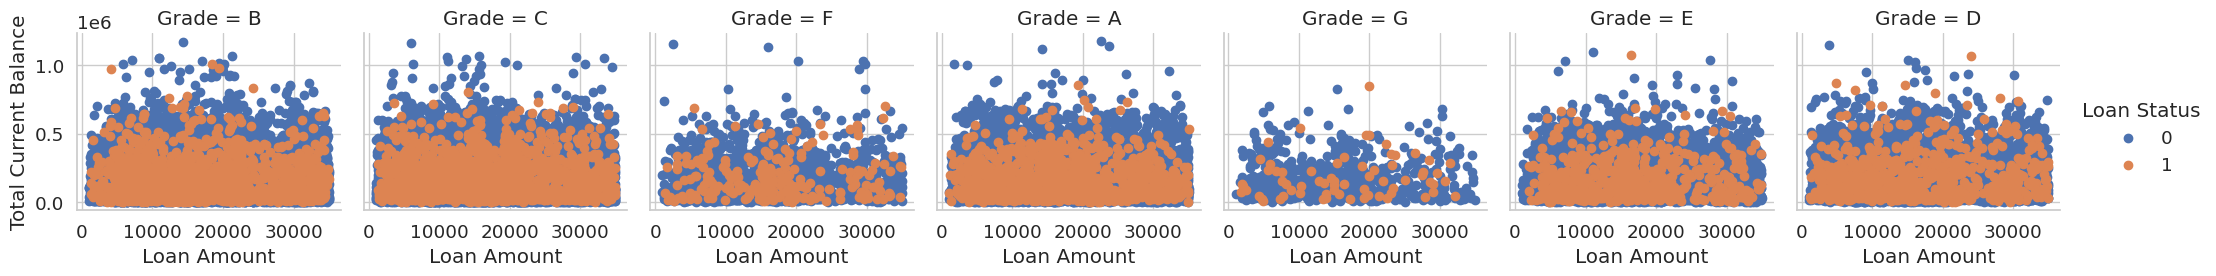

In [22]:
#train_df[''].value_counts()
sns.FacetGrid(data = train_df, col = 'Grade', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Total Current Balance').add_legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

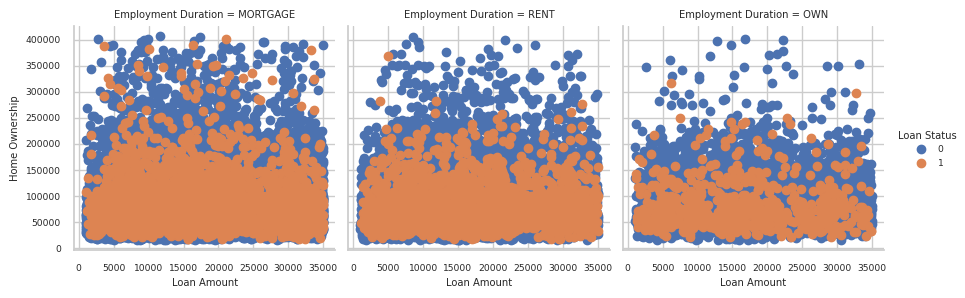

In [23]:
sns.set(style="whitegrid", font_scale=.6)
fig = plt.figure(figsize=(12, 8))
sns.FacetGrid(data = train_df, col = 'Employment Duration', hue='Loan Status').map(plt.scatter, 'Loan Amount', 'Home Ownership').add_legend()


plt.show()


###Correlation

<ipython-input-24-cbae18087f8d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


<Axes: >

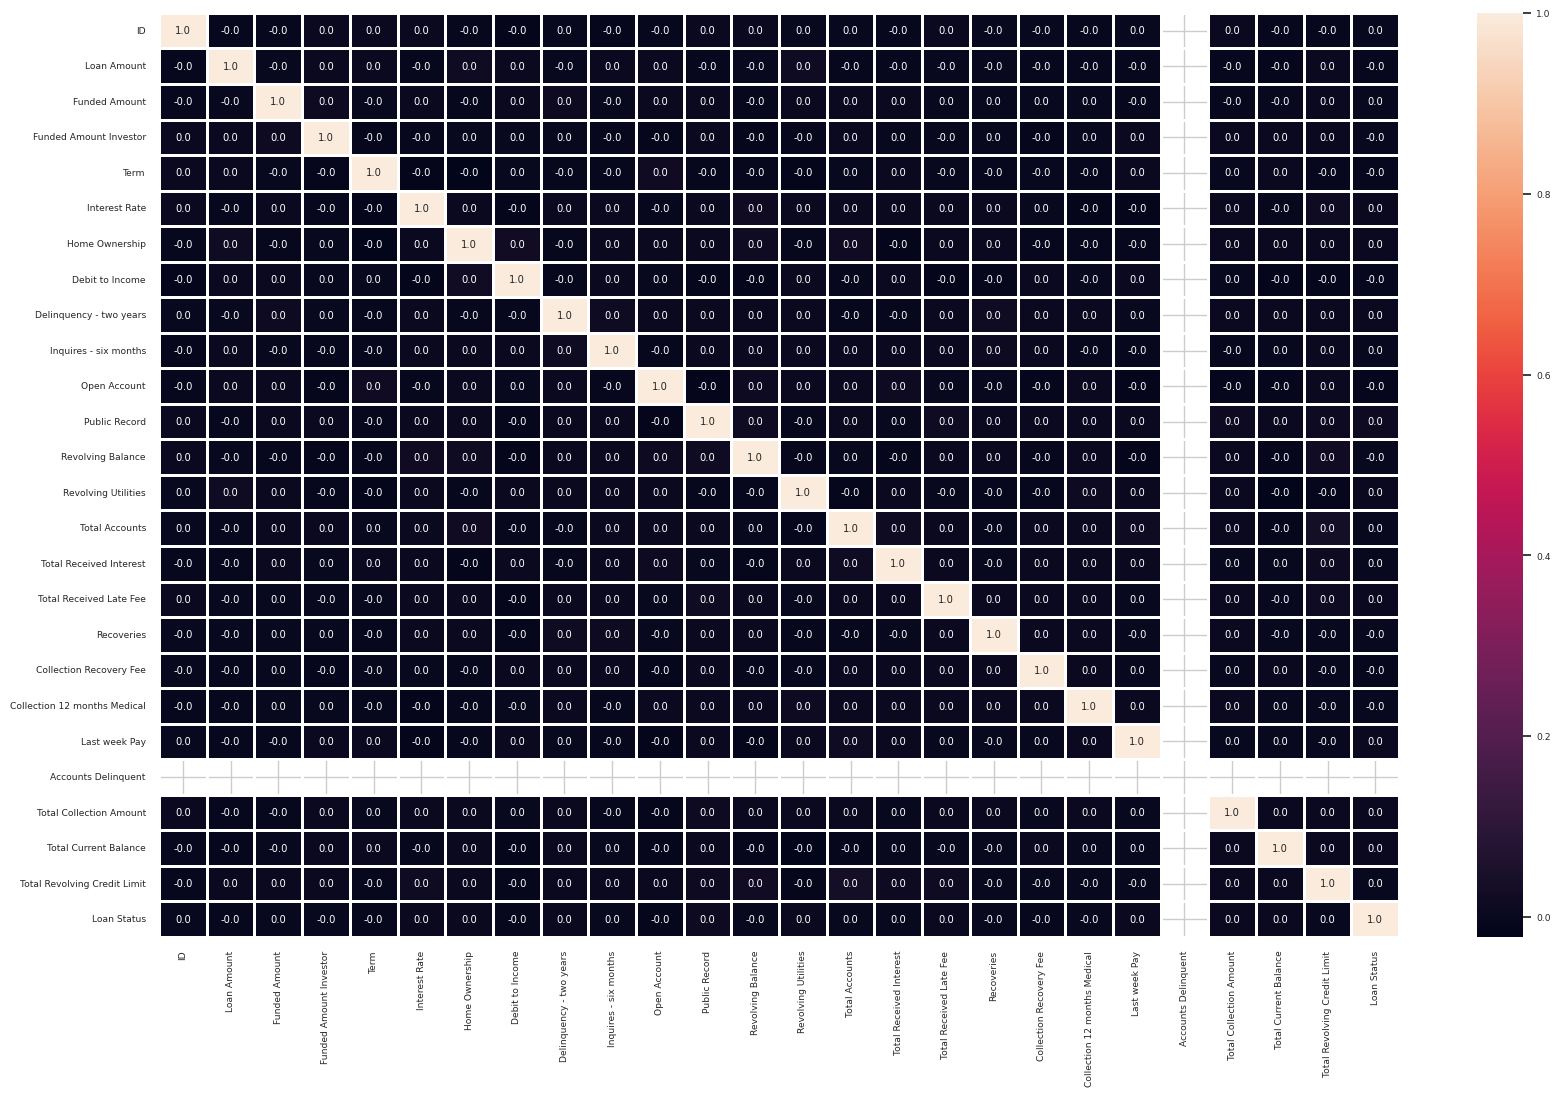

In [24]:
#Select and analyse important numerical features
corr = train_df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr,annot=True,linewidths=1,fmt='.1f')

Shows no correlation between features

##Model Building

###Preparing Dataframe for initial model training based on EDA

In [25]:
train_df

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,...,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,...,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,16164945,13601,6848,13175.28583,59,BAT3193689,9.408858,C,A4,MORTGAGE,...,564.614852,0.865230,0,INDIVIDUAL,69,0,48,181775,34301,1
67459,35182714,8323,11046,15637.46301,59,BAT1780517,9.972104,C,B3,RENT,...,2.015494,1.403368,0,INDIVIDUAL,14,0,37,22692,8714,0
67460,16435904,15897,32921,12329.45775,59,BAT1761981,19.650943,A,F3,MORTGAGE,...,5.673092,1.607093,0,INDIVIDUAL,137,0,17,176857,42330,0
67461,5300325,16567,4975,21353.68465,59,BAT2333412,13.169095,D,E3,OWN,...,1.157454,0.207608,0,INDIVIDUAL,73,0,61,361339,39075,0


In [26]:
train_df.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [28]:
#changing 'Term' to category from numeric
train_df['Term']=train_df['Term'].astype("str")

In [29]:
#removing some columns as per earlier analysis
train_df_upd = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_upd = train_df_upd.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
train_df_upd.head(2)

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,B,MORTGAGE,176346.6267,Not Verified,16.284758,...,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,C,RENT,39833.9210,Source Verified,15.412409,...,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,53,182610,20885,0


In [30]:
rem_cols = train_df_upd.columns

In [31]:
#unique values in remaining columns
for i in rem_cols:
    print("The no.of unique values in",i,"are: ",train_df_upd.loc[:,i].nunique())

The no.of unique values in Loan Amount are:  27525
The no.of unique values in Funded Amount are:  24548
The no.of unique values in Funded Amount Investor are:  67441
The no.of unique values in Term are:  3
The no.of unique values in Interest Rate are:  67448
The no.of unique values in Grade are:  7
The no.of unique values in Employment Duration are:  3
The no.of unique values in Home Ownership are:  67454
The no.of unique values in Verification Status are:  3
The no.of unique values in Debit to Income are:  67454
The no.of unique values in Delinquency - two years are:  9
The no.of unique values in Inquires - six months are:  6
The no.of unique values in Open Account are:  36
The no.of unique values in Public Record are:  5
The no.of unique values in Revolving Balance are:  20582
The no.of unique values in Revolving Utilities are:  67458
The no.of unique values in Total Accounts are:  69
The no.of unique values in Initial List Status are:  2
The no.of unique values in Total Received Int

In [32]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

df shape before: (67463, 29)
df shape after: (67463, 43)


In [33]:
train_df_upd_enc

,Loan Amount,Funded Amount,Funded Amount Investor,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,...,Employment Duration_MORTGAGE,Employment Duration_OWN,Employment Duration_RENT,Verification Status_Not Verified,Verification Status_Source Verified,Verification Status_Verified,Initial List Status_f,Initial List Status_w,Application Type_INDIVIDUAL,Application Type_JOINT
0,10000,32236,12329.36286,11.135007,176346.62670,16.284758,1,0,13,0,...,1,0,0,1,0,0,0,1,1,0
1,3609,11940,12191.99692,12.237563,39833.92100,15.412409,0,0,12,0,...,0,0,1,0,1,0,1,0,1,0
2,28276,9311,21603.22455,12.545884,91506.69105,28.137619,0,0,14,0,...,1,0,0,0,1,0,0,1,1,0
3,11170,6954,17877.15585,16.731201,108286.57590,18.043730,1,0,7,0,...,1,0,0,0,1,0,0,1,1,0
4,16890,13226,13539.92667,15.008300,44234.82545,17.209886,1,3,13,1,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,13601,6848,13175.28583,9.408858,83961.15003,28.105127,1,0,13,0,...,1,0,0,0,0,1,0,1,1,0
67459,8323,11046,15637.46301,9.972104,65491.12817,17.694279,0,0,12,0,...,0,0,1,0,1,0,0,1,1,0
67460,15897,32921,12329.45775,19.650943,34813.96985,10.295774,0,0,7,1,...,1,0,0,0,0,1,0,1,1,0
67461,16567,4975,21353.68465,13.169095,96938.83564,7.614624,0,0,14,0,...,0,1,0,1,0,0,1,0,1,0


In [34]:
#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

In [35]:
y_train.value_counts()

0    42842
1     4382
Name: Loan Status, dtype: int64

In [36]:
y_test.value_counts()

0    18380
1     1859
Name: Loan Status, dtype: int64

In [37]:
#function to train and check accuracy for few models - decision tree; random forest; kNN; Gaussian NB; and XG Boost
def model_results_compare(X_train, y_train, X_test, y_test):
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  knn = KNeighborsClassifier()
  gnb = GaussianNB()
  xgb = XGBClassifier()

  model_list = [dt,rf,knn,gnb,xgb]
  model_list_names = ['Decision Tree','Random Forest','K Neighbors Classifier','Gaussian NB','XGBClassifier']
  train_acc = []
  test_acc = []
  test_roc = []
  train_log_loss = []
  test_log_loss = []

  for i in model_list:
      i_model = i.fit(X_train,y_train)
      ypred_train = i_model.predict(X_train)
      ypred_test = i_model.predict(X_test)
      train_acc.append(accuracy_score(y_train,ypred_train))
      test_acc.append(accuracy_score(y_test,ypred_test))
      test_roc.append(roc_auc_score(y_test,ypred_test))

  val = 0
  for i in model_list_names:
    print(f'training accuracy for {i} is {train_acc[val]}')
    print(f'testing accuracy for {i} is {test_acc[val]}')
    print(f'roc_score for {i} is {i} is {test_roc[val]}\n\n')
    val+=1

###Model Iter - 1

In [38]:
#comparing with initial column list
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8192598448539947
roc_score for Decision Tree is Decision Tree is 0.49941260087531114


training accuracy for Random Forest is 0.9999364729798408
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9018726221651268
roc_score for Gaussian NB is Gaussian NB is 0.5011385659623712


training accuracy for XGBClassifier is 0.9243816703371167
testing accuracy for XGBClassifier is 0.9071594446365927
roc_score for XGBClassifier is XGBClassifier is 0.499455930359086




###Model Iter - 2

In [39]:
#removing 'Delinquency - two years', 'Public Record', 'Collection 12 months Medical' from numerical cols

train_df_upd = train_df_upd.drop(['Public Record','Delinquency - two years', 'Collection 12 months Medical'],axis=1)
train_df_upd.head(2)


,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,B,MORTGAGE,176346.6267,Not Verified,16.284758,...,2929.646315,0.102055,2.498291,0.793724,INDIVIDUAL,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,C,RENT,39833.9210,Source Verified,15.412409,...,772.769385,0.036181,2.377215,0.974821,INDIVIDUAL,109,53,182610,20885,0


In [40]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

df shape before: (67463, 26)
df shape after: (67463, 40)


In [41]:
#comparing with second set of columns
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8180246059587925
roc_score for Decision Tree is Decision Tree is 0.49728196387190277


training accuracy for Random Forest is 1.0
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9018726221651268
roc_score for Gaussian NB is Gaussian NB is 0.5011385659623712


training accuracy for XGBClassifier is 0.9243181433169575
testing accuracy for XGBClassifier is 0.9073570828598251
roc_score for XGBClassifier is XGBClassifier is 0.5000482609380241




###Model Iter - 3

In [42]:
#removing next set of columns
train_df_upd = train_df_upd.drop(['Debit to Income','Total Accounts'],axis=1)
train_df_upd.head(2)

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Inquires - six months,...,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,B,MORTGAGE,176346.6267,Not Verified,0,...,2929.646315,0.102055,2.498291,0.793724,INDIVIDUAL,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,C,RENT,39833.9210,Source Verified,0,...,772.769385,0.036181,2.377215,0.974821,INDIVIDUAL,109,53,182610,20885,0


In [43]:
print(f'df shape before: {train_df_upd.shape}')

train_df_upd_enc = pd.get_dummies(train_df_upd)

print(f'df shape after: {train_df_upd_enc.shape}')

#Splitting data into train and test
X = train_df_upd_enc.drop('Loan Status', axis=1)
y = train_df_upd_enc['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7)

df shape before: (67463, 24)
df shape after: (67463, 38)


In [44]:
#comparing with third set of columns
model_results_compare(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.8113049063688917
roc_score for Decision Tree is Decision Tree is 0.4952745985913309


training accuracy for Random Forest is 0.9999788243266136
testing accuracy for Random Forest is 0.9081476357527546
roc_score for Random Forest is Random Forest is 0.5


training accuracy for K Neighbors Classifier is 0.9087751990513299
testing accuracy for K Neighbors Classifier is 0.9022184890557834
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.4998784403844252


training accuracy for Gaussian NB is 0.900643740470947
testing accuracy for Gaussian NB is 0.9019220317209349
roc_score for Gaussian NB is Gaussian NB is 0.5011657694444168


training accuracy for XGBClassifier is 0.9230264272403862
testing accuracy for XGBClassifier is 0.9072088541924008
roc_score for XGBClassifier is XGBClassifier is 0.499966650491887




###Comparison Model Iter 1, 2 & 3

Removing columns isn't helping towards better prediction, considering all columns and moving towards resampling

###Training with Resampling

In [46]:
#function to train and check accuracy for few models - decision tree; random forest; kNN; Gaussian NB; and XG Boost with resampling
def model_results_compare_resampled(X_train, y_train, X_test, y_test):
  dt = DecisionTreeClassifier()
  rf = RandomForestClassifier()
  knn = KNeighborsClassifier()
  gnb = GaussianNB()
  xgb = XGBClassifier()

  model_list = [dt,rf,knn,gnb,xgb]
  model_list_names = ['Decision Tree','Random Forest','K Neighbors Classifier','Gaussian NB','XGBClassifier']
  train_acc = []
  test_acc = []
  test_roc = []
  train_log_loss = []
  test_log_loss = []

  for i in model_list:
      i_model = i.fit(X_train,y_train)
      ypred_train = i_model.predict(X_train)
      ypred_test = i_model.predict(X_test)
      train_acc.append(accuracy_score(y_train,ypred_train))
      test_acc.append(accuracy_score(y_test,ypred_test))
      test_roc.append(roc_auc_score(y_test,ypred_test))
      train_log_loss.append(log_loss(ypred_train,y_train))
      test_log_loss.append(log_loss(ypred_test,y_test))

  val = 0
  for i in model_list_names:
    print(f'training accuracy for {i} is {train_acc[val]}')
    print(f'testing accuracy for {i} is {test_acc[val]}')
    print(f'roc_score for {i} is {i} is {test_roc[val]}')
    print(f'train_log_loss for {i} is {train_log_loss[val]}')
    print(f'test_log_loss for {i} is {test_log_loss[val]}\n\n')
    val+=1

In [62]:
#removing columns from analysis
train_df_fl = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_fl = train_df_fl.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
train_df_fl.head(2)

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,B,MORTGAGE,176346.6267,Not Verified,16.284758,...,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,C,RENT,39833.9210,Source Verified,15.412409,...,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,53,182610,20885,0


In [63]:
print(f'df shape before: {train_df_fl.shape}')

train_df_fl_enc = pd.get_dummies(train_df_fl)

print(f'df shape after: {train_df_fl_enc.shape}')

#Splitting data into train and test
X = train_df_fl_enc.drop('Loan Status', axis=1)
y = train_df_fl_enc['Loan Status']

print(f'mean of y: {y.mean()}')

#resample
sampler = RandomOverSampler()
X_res,y_res = sampler.fit_resample(X,y)

#print(y_res.mean())
print(f'mean of y after resampling: {y_res.mean()}')

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.7, random_state=0)

df shape before: (67463, 29)
df shape after: (67463, 43)
mean of y: 0.09250996842713784
mean of y after resampling: 0.5


In [49]:
#comparing with all columns with resampling
model_results_compare_resampled(X_train, y_train, X_test, y_test)

training accuracy for Decision Tree is 1.0
testing accuracy for Decision Tree is 0.9324876136549246
roc_score for Decision Tree is Decision Tree is 0.9323631120972928
train_log_loss for Decision Tree is 2.2204460492503136e-16
test_log_loss for Decision Tree is 2.433393052894064


training accuracy for Random Forest is 1.0
testing accuracy for Random Forest is 0.9998094408449938
roc_score for Random Forest is Random Forest is 0.9998097929460356
train_log_loss for Random Forest is 2.2204460492503136e-16
test_log_loss for Random Forest is 0.00686844813316895


training accuracy for K Neighbors Classifier is 0.8816590829541477
testing accuracy for K Neighbors Classifier is 0.827680078401481
roc_score for K Neighbors Classifier is K Neighbors Classifier is 0.8273970830969919
train_log_loss for K Neighbors Classifier is 4.265438995750966
test_log_loss for K Neighbors Classifier is 6.211039526136864


training accuracy for Gaussian NB is 0.5104538560261347
testing accuracy for Gaussian NB is 

Decision Tree, Random Forest and KNN are doing well, however, huge gap in train and test loss confirms overfitting.

Gaussian NB didn't perform well.

On the other hand, XGB roc_auc score is 84% with least gap in train and test loss (least overfitting). Let's try if we can tune hyperparameter of XGB and can get better results.

##Submission - 2

###Try out new models

####Preparing resampled data

In [50]:
#changing 'Term' to category from numeric
train_df['Term']=train_df['Term'].astype("str")

#removing columns from analysis
train_df_fl = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_fl = train_df_fl.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
train_df_fl.head(2)

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,11.135007,B,MORTGAGE,176346.6267,Not Verified,16.284758,...,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,31,311301,6619,0
1,3609,11940,12191.99692,59,12.237563,C,RENT,39833.9210,Source Verified,15.412409,...,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,53,182610,20885,0


In [51]:
print(f'df shape before: {train_df_fl.shape}')

train_df_fl_enc = pd.get_dummies(train_df_fl)

print(f'df shape after: {train_df_fl_enc.shape}')

#Splitting data into train and test
X = train_df_fl_enc.drop('Loan Status', axis=1)
y = train_df_fl_enc['Loan Status']
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.7, stratify=y)
print(f'mean of y: {y.mean()}')

#resample
sampler = RandomOverSampler()
X_res,y_res = sampler.fit_resample(X,y)

#print(y_res.mean())
print(f'mean of y after resampling: {y_res.mean()}')

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.7, random_state=0)

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=0)

df shape before: (67463, 29)
df shape after: (67463, 43)
mean of y: 0.09250996842713784
mean of y after resampling: 0.5


In [52]:
y_train.value_counts()

0    42889
1    42821
Name: Loan Status, dtype: int64

In [53]:
y_test.value_counts()

1    18401
0    18333
Name: Loan Status, dtype: int64

####**LogisticRegression**

In [54]:
#with default hyperparameters
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
score = lr_clf.score(X_test, y_test)

print(score)

ypred_train = lr_clf.predict(X_train)

print(f'training accuracy is {accuracy_score(y_train, ypred_train)}')
print(f'testing accuracy is {accuracy_score(y_test, y_pred)}')
print(f'roc_score for is {roc_auc_score(y_test, y_pred)}')
print(f'train_log_loss is {log_loss(ypred_train, y_train, labels=[0,1])}')
print(f'test_log_loss is {log_loss(y_pred, y_test, labels=[0,1])}')


0.5086296074481407
training accuracy is 0.5104538560261347
testing accuracy is 0.5086296074481407
roc_score for is 0.5086754950450166
train_log_loss is 17.64503153137284
test_log_loss is 17.710784114813645


roc_auc score is just 0.5 (same as GaussianNB from last attempted models), trying hyperparameter tuning for better score

#####**First set of hyperparameters:** with L1 Penalty

In [55]:
C = [] #C: from 0.1 to 1, step = 0.3
i = 0.1
while i<=1:
  C.append(round(i,1))
  i += 0.3

C

[0.1, 0.4, 0.7, 1.0]

Commented next cell, as it takes too much time to fit multiple parameter ranges

In [15]:
'''
lr_clf_multiTest = LogisticRegression()

param_grid_multi = {'C': C,                  #Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization
          'multi_class': ['auto', 'ovr'],
          'solver': ['liblinear', 'saga'],      #Algorithm to use in the optimization problem
          'penalty': ['l1', 'l2']
              }

# Perform grid search
grid_search_multi = GridSearchCV(lr_clf_multiTest, param_grid_multi, cv=5, scoring='roc_auc')
grid_search_multi.fit(X_train, y_train)


# Get the best hyperparameters
best_params = grid_search_multi.best_params_
# Print the best hyperparameters
print('Best hyperparameters for Logistic Regression with Multiple Parameters:\n', grid_search_multi.best_params_)

# Use the best model to make predictions on the test data
y_pred = grid_search_multi.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

print(f'Accuracy of best Logistic Regression: {accuracy_score(y_test, y_pred)}')
'''


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best hyperparameters for Logistic Regression with Multiple Parameters:
 {'C': 0.7, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.52      0.53      0.53     18333
           1       0.53      0.52      0.52     18401

    accuracy                           0.53     36734
   macro avg       0.53      0.53      0.53     36734
weighted avg       0.53      0.53      0.53     36734

Accuracy of best Logistic Regression: 0.5250449175151086


**Testing best parameters from first results**

0.5280121957859204
training accuracy is 0.529914829074787
testing accuracy is 0.5280121957859204
roc_score is 0.5280107799737783
train_log_loss is 16.943586964192264
test_log_loss is 17.01216481898277


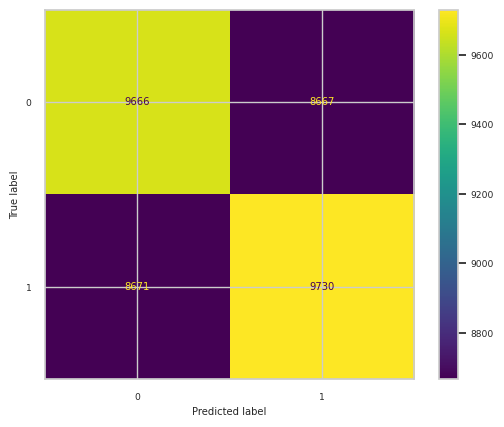

              precision    recall  f1-score   support

           0       0.53      0.53      0.53     18333
           1       0.53      0.53      0.53     18401

    accuracy                           0.53     36734
   macro avg       0.53      0.53      0.53     36734
weighted avg       0.53      0.53      0.53     36734

F1 Score: 0.5288330887548236
roc_auc_score: 0.5280107799737783
Train_loss: 16.943586964192264
Test_Loss: 17.01216481898277


In [56]:
#Best hyperparameters for Logistic Regression with Multiple Parameters:
#{'C': 0.7, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}

lr_clf = LogisticRegression(random_state=0,  penalty="l1", solver='liblinear', multi_class="auto", C=0.7, max_iter=500)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
score = lr_clf.score(X_test, y_test)

print(score)

ypred_train = lr_clf.predict(X_train)

print(f'training accuracy is {accuracy_score(y_train, ypred_train)}')
print(f'testing accuracy is {accuracy_score(y_test, y_pred)}')
print(f'roc_score is {roc_auc_score(y_test, y_pred)}')
print(f'train_log_loss is {log_loss(y_train, ypred_train, labels=[0, 1])}')
print(f'test_log_loss is {log_loss(y_pred, y_test, labels=[0, 1])}')



# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred)}')
print('Train_loss:',log_loss(ypred_train,y_train, labels=[0, 1]))
print('Test_Loss:',log_loss(y_pred,y_test, labels=[0, 1]))

#####**Second set of hyperparameters:** with L2 Penalty

Commented next cell, as it takes too much time to fit multiple parameter ranges

In [17]:
'''
lr_clf_multiTest = LogisticRegression()

param_grid_multi = {'C': C,                  #Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization
          'multi_class': ['auto', 'ovr', ],
          'solver': ['newton-cg', 'lbfgs'],      #Algorithm to use in the optimization problem
          'penalty': ['l2', None]
              }

# Perform grid search
grid_search_multi = GridSearchCV(lr_clf_multiTest, param_grid_multi, cv=5, scoring='roc_auc')
grid_search_multi.fit(X_train, y_train)


# Get the best hyperparameters
best_params = grid_search_multi.best_params_
# Print the best hyperparameters
print('Best hyperparameters for Logistic Regression with Multiple Parameters:\n', grid_search_multi.best_params_)

# Use the best model to make predictions on the test data
y_pred = grid_search_multi.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

print(f'Accuracy of best Logistic Regression: {accuracy_score(y_test, y_pred)}')

'''

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.

Best hyperparameters for Logistic Regression with Multiple Parameters:
 {'C': 0.7, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.52      0.53      0.53     18333
           1       0.53      0.52      0.52     18401

    accuracy                           0.53     36734
   macro avg       0.53      0.53      0.52     36734
weighted avg       0.53      0.53      0.52     36734

Accuracy of best Logistic Regression: 0.5250176947786791


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


**Testing best parameters from second results**

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


0.5275494092666195
training accuracy is 0.529424804573562
testing accuracy is 0.5275494092666195
roc_score is 0.527548445409532
train_log_loss is 16.961249237466596
test_log_loss is 17.028845335877605


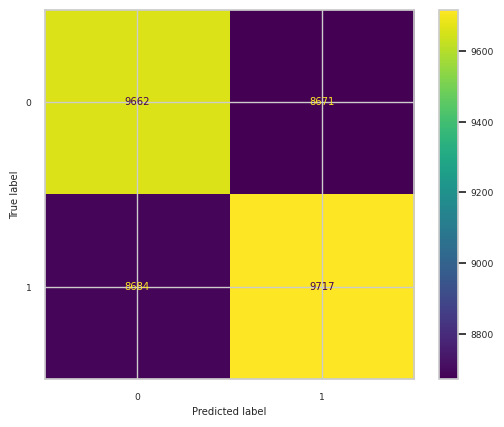

              precision    recall  f1-score   support

           0       0.53      0.53      0.53     18333
           1       0.53      0.53      0.53     18401

    accuracy                           0.53     36734
   macro avg       0.53      0.53      0.53     36734
weighted avg       0.53      0.53      0.53     36734

F1 Score: 0.5282557286145315
roc_auc_score: 0.527548445409532
Train_loss: 16.961249237466596
Test_Loss: 17.028845335877605


In [57]:
#Best hyperparameters for Logistic Regression with Multiple Parameters:
#{'C': 0.7, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}

lr_clf = LogisticRegression(random_state=0,  penalty="l2", solver='newton-cg', multi_class="auto", C=0.7, max_iter=500)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
score = lr_clf.score(X_test, y_test)

print(score)

ypred_train = lr_clf.predict(X_train)

print(f'training accuracy is {accuracy_score(y_train, ypred_train)}')
print(f'testing accuracy is {accuracy_score(y_test, y_pred)}')
print(f'roc_score is {roc_auc_score(y_test, y_pred)}')
print(f'train_log_loss is {log_loss(y_train, ypred_train, labels=[0, 1])}')
print(f'test_log_loss is {log_loss(y_pred, y_test, labels=[0, 1])}')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred)}')
print('Train_loss:',log_loss(ypred_train,y_train, labels=[0, 1]))
print('Test_Loss:',log_loss(y_pred,y_test, labels=[0, 1]))

**Observation:**

Logistic regression, with or without resampling, also with different hyperparameters (rigde, lasso) not generating significant results. TIll now best model to consider is XGBoost (as mentioned in first submission).

####**Support Vector Machine Classifier**

 **Note**: taking too much time to execute  (commented for accidental re-runs)

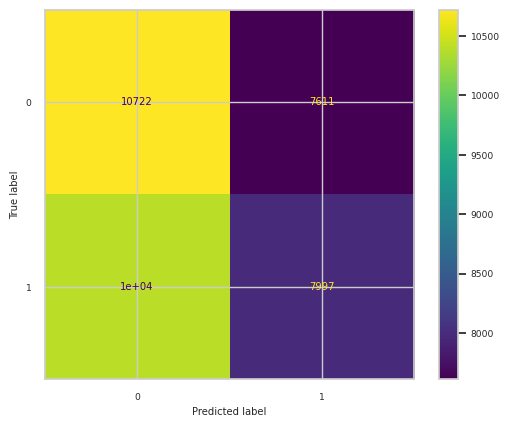

              precision    recall  f1-score   support

           0       0.51      0.58      0.54     18333
           1       0.51      0.43      0.47     18401

    accuracy                           0.51     36734
   macro avg       0.51      0.51      0.51     36734
weighted avg       0.51      0.51      0.51     36734

F1 Score: 0.4702872768972919
roc_auc_score: 0.509721471545319


In [29]:
'''
svm_clf = SVC()

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred)}')

#score = svm_clf.score(X_test, y_test)

#plt.figure(figsize=(6,4))
#sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
#plt.ylabel('Actual label');
#plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15);

#plt.show()
#print(metrics.classification_report(y_test, y_pred))

'''

In [59]:
C = [] #C: from 0.1 to 1, step = 0.3
i = 0.1
while i<=1:
  C.append(round(i,1))
  i += 0.3

C

[0.1, 0.4, 0.7, 1.0]

**Note**: taking too much time to execute (>1 hour; commented for accidental re-runs)

In [18]:
'''
%%timeit
# Define the SVM SVC model

svm_clf = SVC()   #gamma if ‘auto’, uses 1 / n_features; if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var())

#ceating Parameter grid
param_grid = {'degree': [4, 5],           #Degree of the polynomial kernel function (‘poly’) [2, 3, 4, 5]
              'C': C,                           #Regularization parameter. The strength of the regularization is inversely proportional to C
              'kernel': ['poly', 'rbf']         #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'. ['poly', 'rbf']
              }


# Perform grid search   --    precision_macro,
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy')  #weighted, recall_macro  --> cross_val_score(clf, X, y, cv=5, scoring='recall_macro')
grid_search.fit(X_train, y_train)


# Get the best hyperparameters
best_params = grid_search.best_params_
# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

#Best hyperparameters: {'C': 0.7, 'degree': 5, 'kernel': 'poly'}

'''

"\n%%timeit\n# Define the SVM SVC model\n\nsvm_clf = SVC()   #gamma if ‘auto’, uses 1 / n_features; if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var())\n\n#ceating Parameter grid\nparam_grid = {'degree': [4, 5],           #Degree of the polynomial kernel function (‘poly’) [2, 3, 4, 5]\n              'C': C,                           #Regularization parameter. The strength of the regularization is inversely proportional to C\n              'kernel': ['poly', 'rbf']         #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'. ['poly', 'rbf']\n              }\n\n\n# Perform grid search   --    precision_macro,\ngrid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy')  #weighted, recall_macro  --> cross_val_score(clf, X, y, cv=5, scoring='recall_macro')\ngrid_search.fit(X_train, y_train)\n\n\n# Get the best hyperparameters\nbest_params = grid_search.best_params_\n# Print the best hyperparameters\nprint('Best hyperparameters:', grid_search.best_param

with best hyperparameters (commented for accidental re-runs; >30 minutes)

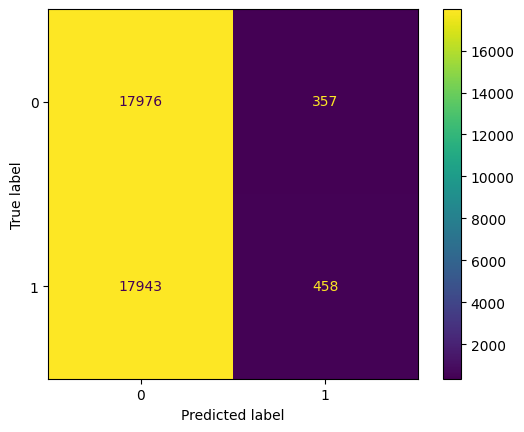

              precision    recall  f1-score   support

           0       0.50      0.98      0.66     18333
           1       0.56      0.02      0.05     18401

    accuracy                           0.50     36734
   macro avg       0.53      0.50      0.36     36734
weighted avg       0.53      0.50      0.35     36734

F1 Score: 0.04766860949208993
roc_auc_score: 0.5027084351521559


In [17]:
'''
svm_clf = SVC(C=0.7, degree=5, kernel='poly')

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred)}')


'''

Not producing better results as roc_auc_score is at 0.509721471545319

###Hyperparameter tuning for best model from resampling (submission 1 & 2) - **XGBoost**

**Parameter Grids (Tried):**

**Set:1**
param_grid = {

              'max_depth': [3, 5, 7],

              'n_estimators': [50, 100, 250]
             
             }


**Set:2**
param_grid = {
  
              'max_depth': [3, 4, 5, 6, 7, 8],
              
              'n_estimators': [50, 100, 200, 250],
              
              'learning_rate': [0.01, 0.1],
              
              'subsample': [0.5, 0.8],
              
              'colsample_bytree': [0.5, 0.8]
             
             }


In [60]:
##Takes time as there are so many parameters to tune

xgb = XGBClassifier(n_jobs=-1)

#param_grid = {'max_depth': [3, 4, 5, 6, 7, 8],
#              'n_estimators': [50, 100, 200, 250],
#              'learning_rate': [0.01, 0.1],
#              'subsample': [0.5, 0.8],
#              'colsample_bytree': [0.5, 0.8]
#             }

param_grid = {'max_depth': [3, 5, 7],
              'n_estimators': [50, 100, 250]
             }


xgb_grid = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train,y_train)


# Get the best hyperparameters
best_params = xgb_grid.best_params_
# Print the best hyperparameters
print('Best hyperparameters:', xgb_grid.best_params_)


Best hyperparameters: {'max_depth': 7, 'n_estimators': 250}


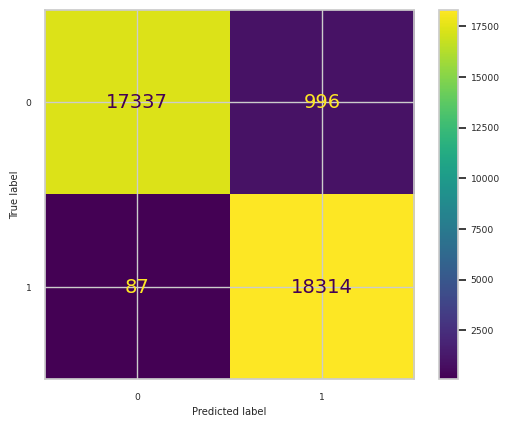

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18333
           1       0.95      1.00      0.97     18401

    accuracy                           0.97     36734
   macro avg       0.97      0.97      0.97     36734
weighted avg       0.97      0.97      0.97     36734

F1 Score: 0.9712815889263081
roc_auc_score: 0.9704718677866708
Train_loss: 0.07948022973449027
Test_Loss: 1.0626470468888194


In [64]:
plt.rcParams['font.size'] = 14

#Best hyperparameters set-1: {'max_depth': 7, 'n_estimators': 250}
xgb_best = XGBClassifier(max_depth=7, n_estimators=250)
xgb_best.fit(X_train,y_train)
train_pred = xgb_best.predict(X_train)
y_pred = xgb_best.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test,y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test,y_pred)}')
print('Train_loss:',log_loss(train_pred,y_train))
print('Test_Loss:',log_loss(y_pred,y_test))

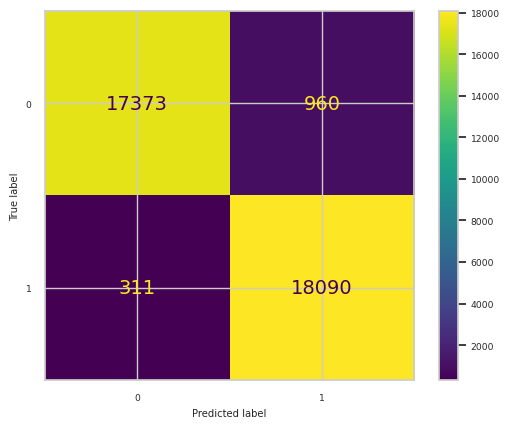

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     18333
           1       0.95      0.98      0.97     18401

    accuracy                           0.97     36734
   macro avg       0.97      0.97      0.97     36734
weighted avg       0.97      0.97      0.97     36734

F1 Score: 0.9660623214333396
roc_auc_score: 0.9653670780931906
Train_loss: 0.3095103126168504
Test_Loss: 1.247113939608208


In [65]:
#Best hyperparameters set-2: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}

xgb_best_2 = XGBClassifier(colsample_bytree=0.8, max_depth=8, n_estimators=250, subsample=0.8, learning_rate=0.1)
xgb_best_2.fit(X_train, y_train)
train_pred = xgb_best_2.predict(X_train)
y_pred = xgb_best_2.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test, y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')
print('Train_loss:',log_loss(train_pred, y_train))
print('Test_Loss:',log_loss(y_pred, y_test))

**Best hyperparameters:**

**Set:1**
* Best hyperparameters: {'max_depth': 7, 'n_estimators': 250}

* roc_auc_score: 0.9704718677866708

**Set:2**
* Best hyperparameters set-2: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}

* roc_auc_score: 0.9653670780931906


**set-1 produces better results with less execution time; Finalizing XGBoost with set-1 hyperparameters**

###Testing trained model using best hyperparameters with original dataset

df shape before: (67463, 29)
df shape after: (67463, 43)


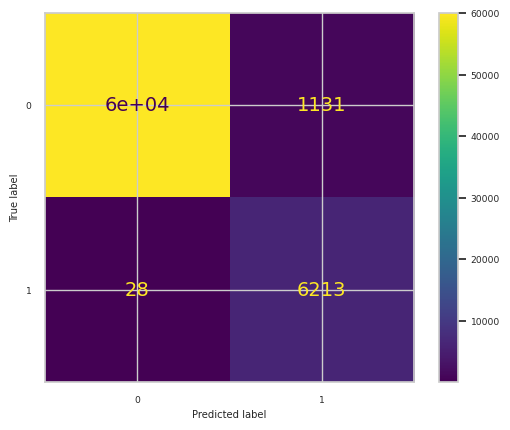

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     61222
           1       0.85      1.00      0.91      6241

    accuracy                           0.98     67463
   macro avg       0.92      0.99      0.95     67463
weighted avg       0.99      0.98      0.98     67463

F1 Score: 0.9146853146853147
roc_auc_score: 0.9885198941154953


In [66]:
#testing original


train_df_orig = train_df.drop(['ID','Payment Plan','Accounts Delinquent'],axis=1)
train_df_orig = train_df_orig.drop(['Batch Enrolled','Sub Grade', 'Loan Title'],axis=1)
print(f'df shape before: {train_df_orig.shape}')
train_df_orig_enc = pd.get_dummies(train_df_orig)
print(f'df shape after: {train_df_orig_enc.shape}')

#Splitting data into train and test
X = train_df_orig_enc.drop('Loan Status', axis=1)
y = train_df_orig_enc['Loan Status']

y_pred = xgb_best.predict(X)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y, y_pred))

print('F1 Score:',f1_score(y, y_pred))
print(f'roc_auc_score: {roc_auc_score(y, y_pred)}')


###With Scaling and Resampling
Try scaling on best model with resampling and tuned hyperparameter

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
np_scaled = scaler.fit_transform(train_df_fl[['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Home Ownership', 'Total Received Interest', 'Recoveries', 'Total Collection Amount','Total Current Balance', 'Total Revolving Credit Limit']])

data_scale = pd.DataFrame(np_scaled)

data_scale.rename(columns = {0:'Loan Amount', 1:'Funded Amount', 2:'Funded Amount Investor', 3:'Home Ownership', 4:'Total Received Interest', 5:'Recoveries', 6:'Total Collection Amount', 7:'Total Current Balance', 8:'Total Revolving Credit Limit'}, inplace = True)

new_df_train = train_df_fl.copy()
#new_df_train[['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Home Ownership', 'Total Received Interest', 'Recoveries', 'Total Collection Amount','Total Current Balance', 'Total Revolving Credit Limit']]
#data_scale[['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Home Ownership', 'Total Received Interest', 'Recoveries', 'Total Collection Amount','Total Current Balance', 'Total Revolving Credit Limit']]
new_df_train[['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Home Ownership', 'Total Received Interest', 'Recoveries', 'Total Collection Amount','Total Current Balance', 'Total Revolving Credit Limit']] = data_scale[['Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Home Ownership', 'Total Received Interest', 'Recoveries', 'Total Collection Amount','Total Current Balance', 'Total Revolving Credit Limit']]

print('scaled DF:')
new_df_train

scaled DF:


,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Grade,Employment Duration,Home Ownership,Verification Status,Debit to Income,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,-0.818483,2.020064,-0.337854,59,11.135007,B,MORTGAGE,2.127642,Not Verified,16.284758,...,0.102055,-0.160195,0.793724,0,INDIVIDUAL,49,-0.155120,1.091309,-0.789041,0
1,-1.582243,-0.469958,-0.358098,59,12.237563,C,RENT,-0.904035,Source Verified,15.412409,...,0.036181,-0.160534,0.974821,0,INDIVIDUAL,109,-0.125565,0.165689,-0.106997,0
2,1.365603,-0.792498,1.028905,59,12.545884,F,MORTGAGE,0.243515,Source Verified,28.137619,...,18.778660,-0.155103,1.020075,0,INDIVIDUAL,66,-0.151090,-0.501847,0.144957,0
3,-0.678661,-1.081668,0.479766,59,16.731201,C,MORTGAGE,0.616163,Source Verified,18.043730,...,0.044131,-0.166892,0.749971,0,INDIVIDUAL,39,-0.143030,-1.081655,1.773285,0
4,0.004911,-0.312185,-0.159444,59,15.008300,C,MORTGAGE,-0.806299,Source Verified,17.209886,...,19.306646,3.459510,0.368953,0,INDIVIDUAL,18,0.380899,-0.241275,-0.026008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,-0.388143,-1.094672,-0.213184,59,9.408858,C,MORTGAGE,0.075944,Verified,28.105127,...,0.023478,1.414257,0.865230,0,INDIVIDUAL,69,-0.132282,0.159683,0.534409,1
67459,-1.018894,-0.579639,0.149686,59,9.972104,C,RENT,-0.334239,Source Verified,17.694279,...,0.027095,-0.161547,1.403368,0,INDIVIDUAL,14,-0.147060,-0.984534,-0.688881,0
67460,-0.113758,2.104103,-0.337840,59,19.650943,A,MORTGAGE,-1.015518,Verified,10.295774,...,0.028212,-0.151302,1.607093,0,INDIVIDUAL,137,-0.173928,0.124310,0.918268,0
67461,-0.033689,-1.324462,0.992129,59,13.169095,D,OWN,0.364152,Not Verified,7.614624,...,0.074508,-0.163950,0.207608,0,INDIVIDUAL,73,-0.114818,1.451211,0.762650,0


In [70]:
print(f'df shape before: {new_df_train.shape}')

new_df_train_enc = pd.get_dummies(new_df_train)

print(f'df shape after: {new_df_train_enc.shape}')

df shape before: (67463, 29)
df shape after: (67463, 43)


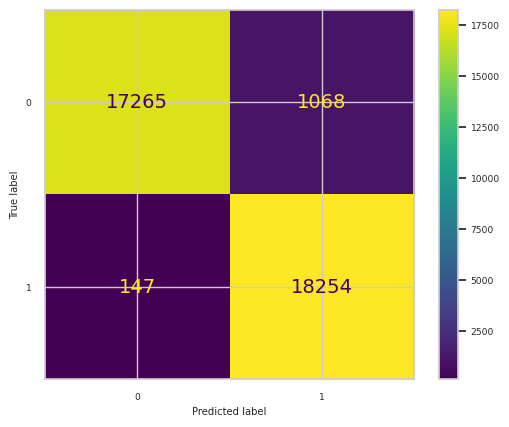

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     18333
           1       0.94      0.99      0.97     18401

    accuracy                           0.97     36734
   macro avg       0.97      0.97      0.97     36734
weighted avg       0.97      0.97      0.97     36734

F1 Score: 0.9677915330169923
roc_auc_score: 0.9668778495430678
Train_loss: 0.11648689754737453
Test_Loss: 1.192166354542858


In [71]:
from sklearn.model_selection import train_test_split


#Splitting data into train and test
X = new_df_train_enc.drop('Loan Status', axis=1)
y = new_df_train_enc['Loan Status']

#resample
sampler = RandomOverSampler()
X_res,y_res = sampler.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.7, random_state=0)



#Best hyperparameters set-1: {'max_depth': 7, 'n_estimators': 250}
xgb_best = XGBClassifier(max_depth=7, n_estimators=250)
xgb_best.fit(X_train, y_train)
train_pred = xgb_best.predict(X_train)
y_pred = xgb_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print(classification_report(y_test, y_pred))
print('F1 Score:',f1_score(y_test, y_pred))
print(f'roc_auc_score: {roc_auc_score(y_test, y_pred)}')
print('Train_loss:',log_loss(train_pred, y_train))
print('Test_Loss:',log_loss(y_pred, y_test))

Without scaling (only resampling); XGBoost; best hyperparameters:


* F1 Score: 0.9712815889263081
* roc_auc_score: 0.9704718677866708
* Train_loss: 0.07948022973449027
* Test_Loss: 1.0626470468888194

With scaling and resampling; XGBoost; best hyperparameters::

* F1 Score: 0.9677915330169923
* roc_auc_score: 0.9668778495430678
* Train_loss: 0.11648689754737453
* Test_Loss: 1.192166354542858


**Scaling is not helpful in this case**

##Conclusion

> Used 7 different ML models:
* Decision Tree
* Random Forest
* K Neighbors Classifier
* Gaussian NB
* XGBClassifier
* Logistic Regression
* SVM


> With and without resampling:
* Resampling producing better results

> Best performance on below parameters:
* Best ROC AUC Score (Area Under the Receiver Operating Characteristic Curve)
* Least Overfitting (Train and Test loss)
* Good Accuracy

> Best performing model:
* XGBoost

Hyperparameter tuning for XGBoost:
* {'max_depth': 7, 'n_estimators': 250}

> Results before tuning
* roc_auc_score: 0.8379963667697358
* Train_loss: 3.8903259538294575
* Test_Loss: 5.836218499441085


> Results after tuning
* roc_auc_score: 0.9704718677866708
* Train_loss: 0.07948022973449027
* Test_Loss: 1.0626470468888194


Performed Scaling on data points and re-ran XGBoost:
* No significant gain from scaling


##References:

https://www.kaggle.com/datasets/hemanthsai7/loandefault

https://www.kaggle.com/code/inagib21/predicting-loan-default

https://www.kaggle.com/code/kartikanagawadi/loandefault

https://www.kaggle.com/code/nitinshelke123/loan-default-prediction

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

